# GroupBy

**Outcomes**
- Understand the split-apply-combine strategy for aggregate computations on groups of data
- Be able use basic aggregation methods on 'df.groupby' to compute within group statistics
- Understand how to group by multiple keys at once

**Data**
- Details for all delayed US domestic flights in December 2016, obtained from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Split-Apply-Combine
One powerful paradigm for analyzing data is the “Split-Apply-Combine” strategy.

This strategy has three steps:
1. `Split`: split the data into groups based on values in one or more columns.
1. `Apply`: apply a function or routine to each group separately.
1. `Combine`: combine the output of the apply step into a DataFrame, using the group identifiers as the index.

We will cover the main components in this notebook, but we encourage you to also study the [official documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html) to learn more about what is possible.

To describe the concepts, we will need some data.

We will begin with a simple made-up dataset to discuss the concepts and then work through extended example and exercises with real data.

In [ ]:
C = np.arange(1, 7, dtype=float)
C[[3, 5]] = np.nan
df = pd.DataFrame({
    "A" : [1, 1, 1, 2, 2, 2],
    "B" : [1, 1, 2, 2, 1, 1],
    "C": C,
})
df

## Simple Example
To perform the *Split* step, we call the groupby method on our DataFrame.
The first argument to `groupby` is a description of how we want to construct groups.
In the most basic version, we will pass a string identifying the column name.

In [ ]:
gbA = df.groupby("A")

The `type` of variable we get back is a `DataFrameGroupBy`, which we will sometimes refer to as GroupBy for short.

In [ ]:
type(gbA)

```
pandas.core.groupby.generic.DataFrameGroupBy
```

Looking at the “groups” inside of the GroupBy object can help us understand what the GroupBy represents.

We can do this with the `gb.get_group(group_name)` method.

In [ ]:
gbA.get_group(1)

In [ ]:
gbA.get_group(2)

We can *apply* some of our favorite aggregation functions directly on the `GroupBy` object.

If we pass a list of strings to `groupby`, it will group based on unique combinations of values from all columns in the list.

Let’s see an example.

In [ ]:
gbAB = df.groupby(["A", "B"])
type(gbAB)

```pandas.core.groupby.generic.DataFrameGroupBy```

In [ ]:
gbAB.get_group((1, 1))

Notice that we still have a `GroupBy` object, so we can apply our favorite aggregations.

In [ ]:
gbAB.count()

Notice that the output is a DataFrame with two levels on the index and a single column `C`. (Quiz: how do we know it is a DataFrame with one column and not a Series?)

This highlights a principle of how pandas handles the *Combine* part of the strategy:

> The index of the combined DataFrame will be the group identifiers, with one index level per group key.

### Custom Aggregate Functions
So far, we have been applying built-in aggregations to our `GroupBy` object.
We can also apply custom aggregations to each group of a GroupBy in two steps:
1. Write our custom aggregation as a Python function.
1. Passing our function as an argument to the .agg method of a GroupBy.

Let’s see an example.

In [ ]:
def num_missing(df):
    "Return the number of missing items in each column of df"
    return df.isnull().sum()

We can call this function on our original DataFrame to get the number of missing items in each column.

In [ ]:
num_missing(df)

We can also apply it to a GroupBy object to get the number of missing items in each column for each group.

In [ ]:
gbA.agg(num_missing)

The key to keep in mind is that the function we pass to `agg` should take in a DataFrame (or Series) and return a Series (or single value) with one item per column in the original DataFrame.
When the function is called, the data for each group will be passed to our function as a DataFrame (or Series).

### Transforms: The `apply` Method
As we saw in the [basics notebook](https://datascience.quantecon.org/pandas/basics.html), we can apply transforms to DataFrames.
We can do the same with GroupBy objects using the `.apply` method.

Let’s see an example.

In [ ]:
df

In [ ]:
def smallest_by_b(df):
    return df.nsmallest(2, "B")

In [ ]:
gbA.apply(smallest_by_b, include_groups=False)

Notice that the return value from applying our series transform to `gbA` was the group key on the outer level (the A column) and the original index from `df` on the inner level.
The original index came along because that was the index of the DataFrame returned by `smallest_by_b`.
Had our function returned something other than the index from `df`, that would appear in the result of the call to `.apply`.

`pd.Grouper`

Sometimes, in order to construct the groups you want, you need to give pandas more information than just a column name.
Some examples are:
- Grouping by a column and a level of the index.
- Grouping time series data at a particular frequency.

pandas lets you do this through the `pd.Grouper` type.

To see it in action, let’s make a copy of `df` with A moved to the index and a Date column added.

In [ ]:
df2 = df.copy()
df2["Date"] = pd.date_range(
    start=pd.Timestamp.today().strftime("%m/%d/%Y"),
    freq="BQE",
    periods=df.shape[0]
)
df2 = df2.set_index("A")
df2

We can group by year.

In [ ]:
df2.groupby(pd.Grouper(key="Date", freq="YE")).count()

We can group by the A level of the index.

In [ ]:
df2.groupby(pd.Grouper(level="A")).count()

We can combine these to group by both.

In [ ]:
df2.groupby([pd.Grouper(key="Date", freq="YE"), pd.Grouper(level="A")]).count()

And we can combine `pd.Grouper` with a string, where the string denotes a column name

In [ ]:
df2.groupby([pd.Grouper(key="Date", freq="YE"), "B"]).count()

# Case Study: Airline Delays
Let’s apply our new split-apply-combine skills to the airline dataset we saw in the [merge](https://datascience.quantecon.org/pandas/merge.html) notebook.

In [ ]:
url = "https://datascience.quantecon.org/assets/data/airline_performance_dec16.csv.zip"
air_dec = pd.read_csv(url, parse_dates = ['Date'])

First, we compute the average delay in arrival time for all carriers each week.

In [ ]:
weekly_delays = (
    air_dec
    .groupby([pd.Grouper(key="Date", freq="W"), "Carrier"])
    ["ArrDelay"]               # extract one column
    .mean()                    # take average
    .unstack(level="Carrier")  # Flip carrier up as column names
)
weekly_delays

Let’s also plot this data.

In [ ]:
# plot
axs = weekly_delays.plot.bar(
    figsize=(10, 8), subplots=True, legend=False, sharex=True,
    sharey=True, layout=(4, 3), grid=False
)

# tweak spacing between subplots and xaxis labels
axs[0,0].get_figure().tight_layout()
for ax in axs[-1, :]:
    ax.set_xticklabels(weekly_delays.index.strftime("%a, %b. %d'"))

It looks like more delays occurred during the week ending Sunday December 18th than any other week (except for Frontier, who did worse on Christmas week).

Let’s see why.

The `air_dec` DataFrame has information on the minutes of delay attributed to 5 different categories:

In [ ]:
delay_cols = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

Let’s take a quick look at each of those delay categories for the week ending December 18, 2016.

In [ ]:
pre_christmas = air_dec.loc[
    (air_dec["Date"] >= "2016-12-12") & (air_dec["Date"] <= "2016-12-18")
]

# custom agg function
def positive(df):
    return (df > 0).sum()

delay_totals = pre_christmas.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])
delay_totals

**Want**: plot total, average, and number of each type of delay by carrier

To do this, we need to have a DataFrame with:
- Delay type in index (so it is on horizontal-axis)
- Aggregation method on outer most level of columns (so we can do `data["mean"]` to get averages)
- Carrier name on inner level of columns

Many sequences of the reshaping commands can accomplish this.

We show one example below.

In [ ]:
reshaped_delays = (
    delay_totals
    .stack()             # move aggregation method into index (with Carrier)
    .T                   # put delay type in index and Carrier+agg in column
    .swaplevel(axis=1)   # make agg method outer level of column label
    .sort_index(axis=1)  # sort column labels so it prints nicely
)
reshaped_delays

In [ ]:
for agg in ["mean", "sum", "positive"]:
    axs = reshaped_delays[agg].plot(
        kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
        sharex=True, sharey=True
    )
    fig = axs[0, 0].get_figure()
    fig.suptitle(agg)
#     fig.tight_layout();

Let’s summarize what we did:
- Computed average flight delay for each airline for each week.
- Noticed that one week had more delays for all airlines.
- Studied the flights in that week to determine the cause of the delays in that week.

Suppose now that we want to repeat that analysis, but at a daily frequency instead of weekly.
We could copy/paste the code from above and change the W to a D, but there’s a better way…

Let’s convert the steps above into two functions:
1. Produce the set of bar charts for average delays at each frequency.
1. Produce the second set of charts for the total, average, and number of occurrences of each type of delay.

In [ ]:
def mean_delay_plot(df, freq, figsize=(10, 8)):
    """
    Make a bar chart of average flight delays for each carrier at
    a given frequency.
    """
    mean_delays = (
        df
        .groupby([pd.Grouper(key="Date", freq=freq), "Carrier"])
        ["ArrDelay"]               # extract one column
        .mean()                    # take average
        .unstack(level="Carrier")  # Flip carrier up as column names
    )

    # plot
    axs = mean_delays.plot.bar(
        figsize=figsize, subplots=True, legend=False, sharex=True,
        sharey=True, layout=(4, 3), grid=False
    )

    # tweak spacing between subplots and x-axis labels
    axs[0, 0].get_figure().tight_layout()
    for ax in axs[-1, :]:
        ax.set_xticklabels(mean_delays.index.strftime("%a, %b. %d'"))

    # return the axes in case we want to further tweak the plot outside the function
    return axs


def delay_type_plot(df, start, end):
    """
    Make bar charts for total minutes, average minutes, and number of
    occurrences for each delay type, for all flights that were scheduled
    between `start` date and `end` date
    """
    sub_df = df.loc[
        (df["Date"] >= start) & (df["Date"] <= end)
    ]

    def positive(df):
        return (df > 0).sum()

    aggs = sub_df.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])

    reshaped = aggs.stack().T.swaplevel(axis=1).sort_index(axis=1)

    for agg in ["mean", "sum", "positive"]:
        axs = reshaped[agg].plot(
            kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
            sharex=True, sharey=True
        )
        fig = axs[0, 0].get_figure()
        fig.suptitle(agg)
#         fig.tight_layout();

Now let’s look at that plot at a daily frequency. (Note that we need the figure to be a bit wider in order to see the dates.)

In [ ]:
mean_delay_plot(air_dec, "D", figsize=(16, 8))

As we expected given our analysis above, the longest average delays seemed to happen in the third week.
In particular, it looks like December 17th and 18th had — on average — higher delays than other days in December.
Let’s use the `delay_type_plot` function to determine the cause of the delays on those two days.

Because our analysis is captured in a single function, we can look at the days together and separately without much effort.

In [ ]:
# both days
delay_type_plot(air_dec, "12-17-16", "12-18-16")

In [ ]:
# only the 17th
delay_type_plot(air_dec, "12-17-16", "12-17-16")

In [ ]:
# only the 18th
delay_type_plot(air_dec, "12-18-16", "12-18-16")

The purpose of this exercise was to drive home the ability to *automate* tasks.

We were able to write a pair of `functions` that allows us to easily repeat the exact same analysis on different subsets of the data, or different datasets entirely (e.g. we could do the same analysis on November 2016 data, with two lines of code).

These principles can be applied in many settings.
Keep that in mind as we work through the rest of the materials.

## Exercise: Cohort Analysis using Shopify Data

The code below will employ a fairly large simulated data set that has the properties of a order-detail report from [Shopify](https://www.shopify.com/).
We’ll first look at the data, and then describe the exercise

In [ ]:
# Set the "randomness" seeds
random.seed(42)
np.random.seed(42)

url = "https://datascience.quantecon.org/assets/data/shopify_orders.csv.zip"
orders = pd.read_csv(url)
orders.info()

orders.head()

We define a customer’s cohort as the month in which a customer placed their first order and the customer type as an indicator of whether this was their first order or a returning order.
We now describe the *want* for the exercise, which we ask you to complete.

**Want**: Compute the monthly total number of orders, total sales, and total quantity separated by customer cohort and customer type.

Read that carefully one more time…

### Extended Exercise
Using the reshape and groupby tools you have learned, apply the want operator described above.
See below for advice on how to proceed.
When you are finished, you should have something that looks like this:
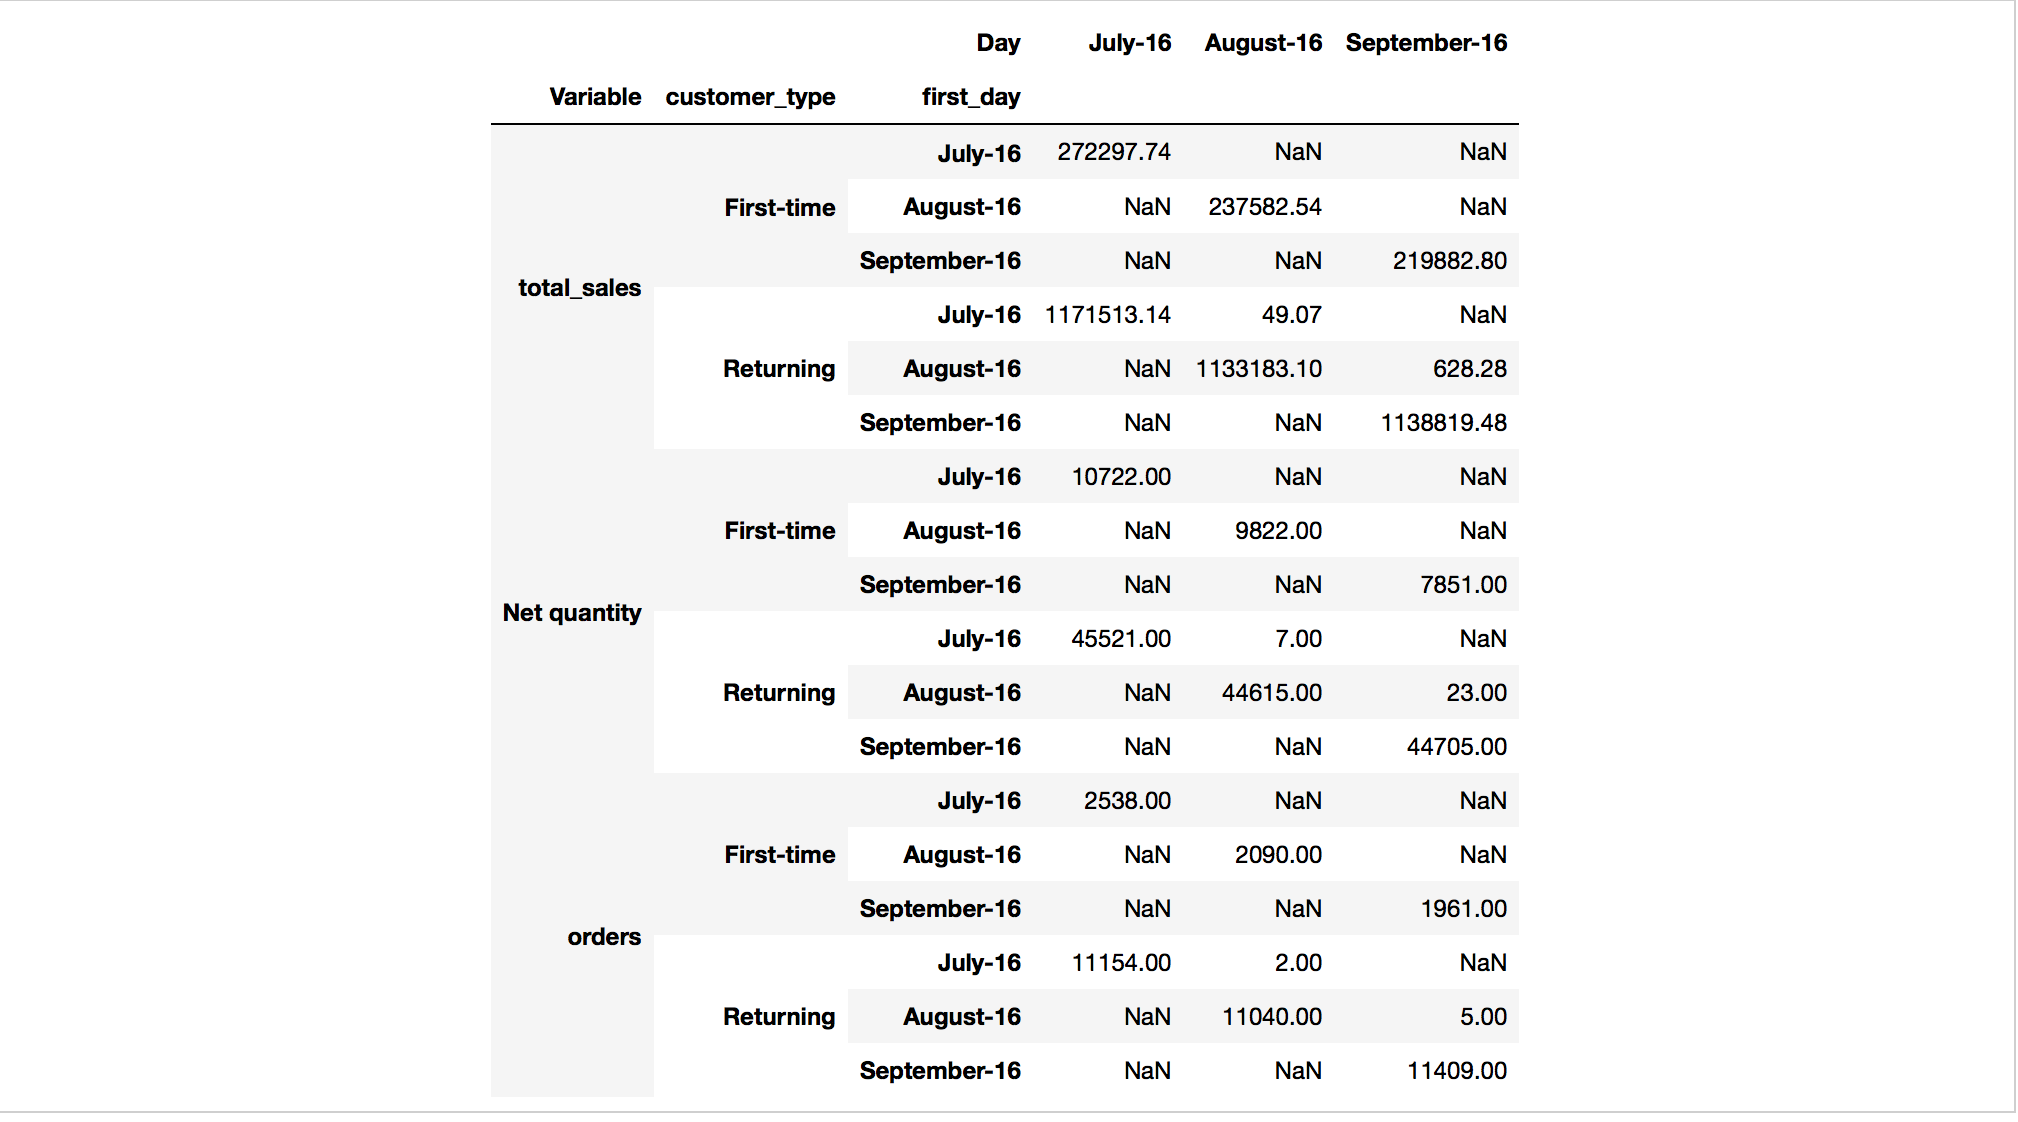

Two notes on the table above:

Your actual output will be much bigger. This is just to give you an : idea of what it might look like.

The numbers you produce should actually be the same as what are : included in this table… Index into your answer and compare what you have with this table to verify your progress.

Now, how to do it?

There is more than one way to code this, but here are some suggested steps.

1. Convert the Day column to have a `datetime` `dtype` instead of object.
    - Hint: Use the `pd.to_datetime` function.

2. Add a new column that specifies the date associated with each customer’s "First-time" order.
    - Hint: You can do this with a combination of `groupby` and `join`.
    - Hint: `customer_type` is always one of `Returning` and `First-time`.
    - Hint:  Some customers don’t have a `customer_type == "First-time"` entry. You will need to set the value for these users to some date that precedes the dates in the sample. After adding valid data back into orders DataFrame, you can identify which customers don’t have a "First-Time" entry by checking for missing data in the new column.

1. You’ll need to group by 3 things.
1. You can apply one of the built-in aggregation functions to the GroupBy.
1. After doing the aggregation, you’ll need to use your reshaping skills to move things to the right place in rows and columns.

Good luck!
